# RL an introduction by Sutton and Barto
## Chapter 8, Planning and Learning with Tabular method
* [solution](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction)
### Dyna Maze

In [1]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import numpy as np
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import heapq
from copy import deepcopy

In [2]:
class PriorityQueue:
    def __init__(self):
        self.pq = []
        self.entry_finder = {}
        self.REMOVED = '<removed-task>'
        self.counter = 0

    def add_item(self, item, priority=0):
        if item in self.entry_finder:
            self.remove_item(item)
        entry = [priority, self.counter, item]
        self.counter += 1
        self.entry_finder[item] = entry
        heapq.heappush(self.pq, entry)

    def remove_item(self, item):
        entry = self.entry_finder.pop(item)
        entry[-1] = self.REMOVED

    def pop_item(self):
        while self.pq:
            priority, count, item = heapq.heappop(self.pq)
            if item is not self.REMOVED:
                del self.entry_finder[item]
                return item, priority
        raise KeyError('pop from an empty priority queue')

    def empty(self):
        return not self.entry_finder

In [3]:
# A wrapper class for a maze, containing all the information about the maze.
# Basically it's initialized to DynaMaze by default, however it can be easily adapted
# to other maze
class Maze:
    def __init__(self):
        # maze width
        self.WORLD_WIDTH = 9

        # maze height
        self.WORLD_HEIGHT = 6

        # all possible actions
        self.ACTION_UP = 0
        self.ACTION_DOWN = 1
        self.ACTION_LEFT = 2
        self.ACTION_RIGHT = 3
        self.actions = [self.ACTION_UP, self.ACTION_DOWN, self.ACTION_LEFT, self.ACTION_RIGHT]

        # start state
        self.START_STATE = [2, 0]

        # goal state
        self.GOAL_STATES = [[0, 8]]

        # all obstacles
        self.obstacles = [[1, 2], [2, 2], [3, 2], [0, 7], [1, 7], [2, 7], [4, 5]]
        self.old_obstacles = None
        self.new_obstacles = None

        # time to change obstacles
        self.obstacle_switch_time = None

        # initial state action pair values
        # self.stateActionValues = np.zeros((self.WORLD_HEIGHT, self.WORLD_WIDTH, len(self.actions)))

        # the size of q value
        self.q_size = (self.WORLD_HEIGHT, self.WORLD_WIDTH, len(self.actions))

        # max steps
        self.max_steps = float('inf')

        # track the resolution for this maze
        self.resolution = 1

    # extend a state to a higher resolution maze
    # @state: state in lower resoultion maze
    # @factor: extension factor, one state will become factor^2 states after extension
    def extend_state(self, state, factor):
        new_state = [state[0] * factor, state[1] * factor]
        new_states = []
        for i in range(0, factor):
            for j in range(0, factor):
                new_states.append([new_state[0] + i, new_state[1] + j])
        return new_states

    # extend a state into higher resolution
    # one state in original maze will become @factor^2 states in @return new maze
    def extend_maze(self, factor):
        new_maze = Maze()
        new_maze.WORLD_WIDTH = self.WORLD_WIDTH * factor
        new_maze.WORLD_HEIGHT = self.WORLD_HEIGHT * factor
        new_maze.START_STATE = [self.START_STATE[0] * factor, self.START_STATE[1] * factor]
        new_maze.GOAL_STATES = self.extend_state(self.GOAL_STATES[0], factor)
        new_maze.obstacles = []
        for state in self.obstacles:
            new_maze.obstacles.extend(self.extend_state(state, factor))
        new_maze.q_size = (new_maze.WORLD_HEIGHT, new_maze.WORLD_WIDTH, len(new_maze.actions))
        # new_maze.stateActionValues = np.zeros((new_maze.WORLD_HEIGHT, new_maze.WORLD_WIDTH, len(new_maze.actions)))
        new_maze.resolution = factor
        return new_maze

    # take @action in @state
    # @return: [new state, reward]
    def step(self, state, action):
        x, y = state
        if action == self.ACTION_UP:
            x = max(x - 1, 0)
        elif action == self.ACTION_DOWN:
            x = min(x + 1, self.WORLD_HEIGHT - 1)
        elif action == self.ACTION_LEFT:
            y = max(y - 1, 0)
        elif action == self.ACTION_RIGHT:
            y = min(y + 1, self.WORLD_WIDTH - 1)
        if [x, y] in self.obstacles:
            x, y = state
        if [x, y] in self.GOAL_STATES:
            reward = 1.0
        else:
            reward = 0.0
        return [x, y], reward


In [4]:
# a wrapper class for parameters of dyna algorithms
class DynaParams:
    def __init__(self):
        # discount
        self.gamma = 0.95

        # probability for exploration
        self.epsilon = 0.1

        # step size
        self.alpha = 0.1

        # weight for elapsed time
        self.time_weight = 0

        # n-step planning
        self.planning_steps = 5

        # average over several independent runs
        self.runs = 10

        # algorithm names
        self.methods = ['Dyna-Q', 'Dyna-Q+']

        # threshold for priority queue
        self.theta = 0

In [5]:
# choose an action based on epsilon-greedy algorithm
def choose_action(state, q_value, maze, dyna_params):
    if np.random.binomial(1, dyna_params.epsilon) == 1:
        return np.random.choice(maze.actions)
    else:
        values = q_value[state[0], state[1], :]
        return np.random.choice([action for action, value in enumerate(values) if value == np.max(values)])

In [6]:
# Trivial model for planning in Dyna-Q
class TrivialModel:
    # @rand: an instance of np.random.RandomState for sampling
    def __init__(self, rand=np.random):
        self.model = dict()
        self.rand = rand

    # feed the model with previous experience
    def feed(self, state, action, next_state, reward):
        state = deepcopy(state)
        next_state = deepcopy(next_state)
        if tuple(state) not in self.model.keys():
            self.model[tuple(state)] = dict()
        self.model[tuple(state)][action] = [list(next_state), reward]

    # randomly sample from previous experience
    def sample(self):
        state_index = self.rand.choice(range(len(self.model.keys())))
        state = list(self.model)[state_index]
        action_index = self.rand.choice(range(len(self.model[state].keys())))
        action = list(self.model[state])[action_index]
        next_state, reward = self.model[state][action]
        state = deepcopy(state)
        next_state = deepcopy(next_state)
        return list(state), action, list(next_state), reward

In [7]:
# Time-based model for planning in Dyna-Q+
class TimeModel:
    # @maze: the maze instance. Indeed it's not very reasonable to give access to maze to the model.
    # @timeWeight: also called kappa, the weight for elapsed time in sampling reward, it need to be small
    # @rand: an instance of np.random.RandomState for sampling
    def __init__(self, maze, time_weight=1e-4, rand=np.random):
        self.rand = rand
        self.model = dict()

        # track the total time
        self.time = 0

        self.time_weight = time_weight
        self.maze = maze

    # feed the model with previous experience
    def feed(self, state, action, next_state, reward):
        state = deepcopy(state)
        next_state = deepcopy(next_state)
        self.time += 1
        if tuple(state) not in self.model.keys():
            self.model[tuple(state)] = dict()

            # Actions that had never been tried before from a state were allowed to be considered in the planning step
            for action_ in self.maze.actions:
                if action_ != action:
                    # Such actions would lead back to the same state with a reward of zero
                    # Notice that the minimum time stamp is 1 instead of 0
                    self.model[tuple(state)][action_] = [list(state), 0, 1]

        self.model[tuple(state)][action] = [list(next_state), reward, self.time]

    # randomly sample from previous experience
    def sample(self):
        state_index = self.rand.choice(range(len(self.model.keys())))
        state = list(self.model)[state_index]
        action_index = self.rand.choice(range(len(self.model[state].keys())))
        action = list(self.model[state])[action_index]
        next_state, reward, time = self.model[state][action]

        # adjust reward with elapsed time since last vist
        reward += self.time_weight * np.sqrt(self.time - time)

        state = deepcopy(state)
        next_state = deepcopy(next_state)

        return list(state), action, list(next_state), reward

In [8]:
# Model containing a priority queue for Prioritized Sweeping
class PriorityModel(TrivialModel):
    def __init__(self, rand=np.random):
        TrivialModel.__init__(self, rand)
        # maintain a priority queue
        self.priority_queue = PriorityQueue()
        # track predecessors for every state
        self.predecessors = dict()

    # add a @state-@action pair into the priority queue with priority @priority
    def insert(self, priority, state, action):
        # note the priority queue is a minimum heap, so we use -priority
        self.priority_queue.add_item((tuple(state), action), -priority)

    # @return: whether the priority queue is empty
    def empty(self):
        return self.priority_queue.empty()

    # get the first item in the priority queue
    def sample(self):
        (state, action), priority = self.priority_queue.pop_item()
        next_state, reward = self.model[state][action]
        state = deepcopy(state)
        next_state = deepcopy(next_state)
        return -priority, list(state), action, list(next_state), reward

    # feed the model with previous experience
    def feed(self, state, action, next_state, reward):
        state = deepcopy(state)
        next_state = deepcopy(next_state)
        TrivialModel.feed(self, state, action, next_state, reward)
        if tuple(next_state) not in self.predecessors.keys():
            self.predecessors[tuple(next_state)] = set()
        self.predecessors[tuple(next_state)].add((tuple(state), action))

    # get all seen predecessors of a state @state
    def predecessor(self, state):
        if tuple(state) not in self.predecessors.keys():
            return []
        predecessors = []
        for state_pre, action_pre in list(self.predecessors[tuple(state)]):
            predecessors.append([list(state_pre), action_pre, self.model[state_pre][action_pre][1]])
        return predecessors

In [9]:
# play for an episode for Dyna-Q algorithm
# @q_value: state action pair values, will be updated. real experience and model experience share it
# @model: model instance for planning
# @maze: a maze instance containing all information about the environment
# @dyna_params: several params for the algorithm
def dyna_q(q_value, model, maze, dyna_params):
    state = maze.START_STATE
    steps = 0
    while state not in maze.GOAL_STATES:
        # track the steps
        steps += 1

        # get action
        action = choose_action(state, q_value, maze, dyna_params)

        # take action
        next_state, reward = maze.step(state, action)

        # Q-Learning update
        q_value[state[0], state[1], action] += \
            dyna_params.alpha * (reward + dyna_params.gamma * np.max(q_value[next_state[0], next_state[1], :]) -
                                 q_value[state[0], state[1], action])

        # feed the model with experience
        model.feed(state, action, next_state, reward)

        # sample experience from the model
        for t in range(0, dyna_params.planning_steps):
            state_, action_, next_state_, reward_ = model.sample()
            q_value[state_[0], state_[1], action_] += \
                dyna_params.alpha * (reward_ + dyna_params.gamma * np.max(q_value[next_state_[0], next_state_[1], :]) -
                                     q_value[state_[0], state_[1], action_])

        state = next_state

        # check whether it has exceeded the step limit
        if steps > maze.max_steps:
            break

    return steps

In [10]:
# play for an episode for prioritized sweeping algorithm
# @q_value: state action pair values, will be updated
# @model: model instance for planning
# @maze: a maze instance containing all information about the environment
# @dyna_params: several params for the algorithm
# @return: # of backups during this episode
def prioritized_sweeping(q_value, model, maze, dyna_params):
    state = maze.START_STATE

    # track the steps in this episode
    steps = 0

    # track the backups in planning phase
    backups = 0

    while state not in maze.GOAL_STATES:
        steps += 1

        # get action
        action = choose_action(state, q_value, maze, dyna_params)

        # take action
        next_state, reward = maze.step(state, action)

        # feed the model with experience
        model.feed(state, action, next_state, reward)

        # get the priority for current state action pair
        priority = np.abs(reward + dyna_params.gamma * np.max(q_value[next_state[0], next_state[1], :]) -
                          q_value[state[0], state[1], action])

        if priority > dyna_params.theta:
            model.insert(priority, state, action)

        # start planning
        planning_step = 0

        # planning for several steps,
        # although keep planning until the priority queue becomes empty will converge much faster
        while planning_step < dyna_params.planning_steps and not model.empty():
            # get a sample with highest priority from the model
            priority, state_, action_, next_state_, reward_ = model.sample()

            # update the state action value for the sample
            delta = reward_ + dyna_params.gamma * np.max(q_value[next_state_[0], next_state_[1], :]) - \
                    q_value[state_[0], state_[1], action_]
            q_value[state_[0], state_[1], action_] += dyna_params.alpha * delta

            # deal with all the predecessors of the sample state
            for state_pre, action_pre, reward_pre in model.predecessor(state_):
                priority = np.abs(reward_pre + dyna_params.gamma * np.max(q_value[state_[0], state_[1], :]) -
                                  q_value[state_pre[0], state_pre[1], action_pre])
                if priority > dyna_params.theta:
                    model.insert(priority, state_pre, action_pre)
            planning_step += 1

        state = next_state

        # update the # of backups
        backups += planning_step + 1

    return backups

100%|██████████| 10/10 [00:36<00:00,  3.79s/it]


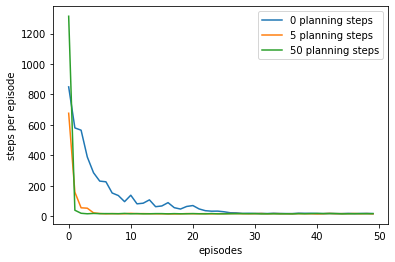

In [11]:
# Figure 8.2, DynaMaze, use 10 runs instead of 30 runs
def figure_8_2():
    # set up an instance for DynaMaze
    dyna_maze = Maze()
    dyna_params = DynaParams()

    runs = 10
    episodes = 50
    planning_steps = [0, 5, 50]
    steps = np.zeros((len(planning_steps), episodes))

    for run in tqdm(range(runs)):
        for i, planning_step in enumerate(planning_steps):
            dyna_params.planning_steps = planning_step
            q_value = np.zeros(dyna_maze.q_size)

            # generate an instance of Dyna-Q model
            model = TrivialModel()
            for ep in range(episodes):
                # print('run:', run, 'planning step:', planning_step, 'episode:', ep)
                steps[i, ep] += dyna_q(q_value, model, dyna_maze, dyna_params)

    # averaging over runs
    steps /= runs

    for i in range(len(planning_steps)):
        plt.plot(steps[i, :], label='%d planning steps' % (planning_steps[i]))
    plt.xlabel('episodes')
    plt.ylabel('steps per episode')
    plt.legend()
figure_8_2()

In [12]:
# wrapper function for changing maze
# @maze: a maze instance
# @dynaParams: several parameters for dyna algorithms
def changing_maze(maze, dyna_params):

    # set up max steps
    max_steps = maze.max_steps

    # track the cumulative rewards
    rewards = np.zeros((dyna_params.runs, 2, max_steps))

    for run in tqdm(range(dyna_params.runs)):
        # set up models for Dyna-Q and Dyna-Q+
        models = [TrivialModel(), TimeModel(maze, time_weight=dyna_params.time_weight)]

        # initialize state action values
        q_values = [np.zeros(maze.q_size), np.zeros(maze.q_size)]

        for i in range(len(dyna_params.methods)):
            # print('run:', run, dyna_params.methods[i])

            # set old obstacles for the maze
            maze.obstacles = maze.old_obstacles

            steps = 0
            last_steps = steps
            while steps < max_steps:
                # play for an episode
                steps += dyna_q(q_values[i], models[i], maze, dyna_params)

                # update cumulative rewards
                rewards[run, i, last_steps: steps] = rewards[run, i, last_steps]
                rewards[run, i, min(steps, max_steps - 1)] = rewards[run, i, last_steps] + 1
                last_steps = steps

                if steps > maze.obstacle_switch_time:
                    # change the obstacles
                    maze.obstacles = maze.new_obstacles

    # averaging over runs
    rewards = rewards.mean(axis=0)

    return rewards

100%|██████████| 20/20 [00:43<00:00,  2.24s/it]


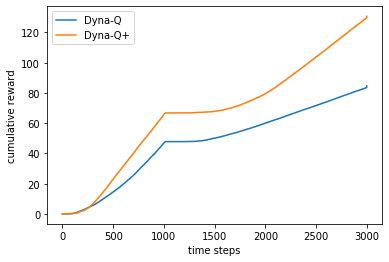

In [13]:
# Figure 8.4, BlockingMaze
def figure_8_4():
    # set up a blocking maze instance
    blocking_maze = Maze()
    blocking_maze.START_STATE = [5, 3]
    blocking_maze.GOAL_STATES = [[0, 8]]
    blocking_maze.old_obstacles = [[3, i] for i in range(0, 8)]

    # new obstalces will block the optimal path
    blocking_maze.new_obstacles = [[3, i] for i in range(1, 9)]

    # step limit
    blocking_maze.max_steps = 3000

    # obstacles will change after 1000 steps
    # the exact step for changing will be different
    # However given that 1000 steps is long enough for both algorithms to converge,
    # the difference is guaranteed to be very small
    blocking_maze.obstacle_switch_time = 1000

    # set up parameters
    dyna_params = DynaParams()
    dyna_params.alpha = 1.0
    dyna_params.planning_steps = 10
    dyna_params.runs = 20

    # kappa must be small, as the reward for getting the goal is only 1
    dyna_params.time_weight = 1e-4

    # play
    rewards = changing_maze(blocking_maze, dyna_params)

    for i in range(len(dyna_params.methods)):
        plt.plot(rewards[i, :], label=dyna_params.methods[i])
    plt.xlabel('time steps')
    plt.ylabel('cumulative reward')
    plt.legend()
    
figure_8_4()

100%|██████████| 5/5 [01:32<00:00, 18.43s/it]


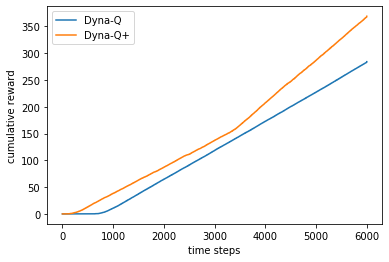

In [14]:
# Figure 8.5, ShortcutMaze
def figure_8_5():
    # set up a shortcut maze instance
    shortcut_maze = Maze()
    shortcut_maze.START_STATE = [5, 3]
    shortcut_maze.GOAL_STATES = [[0, 8]]
    shortcut_maze.old_obstacles = [[3, i] for i in range(1, 9)]

    # new obstacles will have a shorter path
    shortcut_maze.new_obstacles = [[3, i] for i in range(1, 8)]

    # step limit
    shortcut_maze.max_steps = 6000

    # obstacles will change after 3000 steps
    # the exact step for changing will be different
    # However given that 3000 steps is long enough for both algorithms to converge,
    # the difference is guaranteed to be very small
    shortcut_maze.obstacle_switch_time = 3000

    # set up parameters
    dyna_params = DynaParams()

    # 50-step planning
    dyna_params.planning_steps = 50
    dyna_params.runs = 5
    dyna_params.time_weight = 1e-3
    dyna_params.alpha = 1.0

    # play
    rewards = changing_maze(shortcut_maze, dyna_params)

    for i in range(len(dyna_params.methods)):
        plt.plot( rewards[i, :], label=dyna_params.methods[i])
    plt.xlabel('time steps')
    plt.ylabel('cumulative reward')
    plt.legend()
figure_8_5()

In [15]:
# Check whether state-action values are already optimal
def check_path(q_values, maze):
    # get the length of optimal path
    # 14 is the length of optimal path of the original maze
    # 1.2 means it's a relaxed optifmal path
    max_steps = 14 * maze.resolution * 1.2
    state = maze.START_STATE
    steps = 0
    while state not in maze.GOAL_STATES:
        action = np.argmax(q_values[state[0], state[1], :])
        state, _ = maze.step(state, action)
        steps += 1
        if steps > max_steps:
            return False
    return True

run 0, Prioritized Sweeping, maze size 54
run 0, Prioritized Sweeping, maze size 216
run 0, Prioritized Sweeping, maze size 486
run 0, Prioritized Sweeping, maze size 864
run 0, Prioritized Sweeping, maze size 1350
run 0, Dyna-Q, maze size 54
run 0, Dyna-Q, maze size 216
run 0, Dyna-Q, maze size 486
run 0, Dyna-Q, maze size 864
run 0, Dyna-Q, maze size 1350
run 1, Prioritized Sweeping, maze size 54
run 1, Prioritized Sweeping, maze size 216
run 1, Prioritized Sweeping, maze size 486
run 1, Prioritized Sweeping, maze size 864
run 1, Prioritized Sweeping, maze size 1350
run 1, Dyna-Q, maze size 54
run 1, Dyna-Q, maze size 216
run 1, Dyna-Q, maze size 486
run 1, Dyna-Q, maze size 864
run 1, Dyna-Q, maze size 1350
run 2, Prioritized Sweeping, maze size 54
run 2, Prioritized Sweeping, maze size 216
run 2, Prioritized Sweeping, maze size 486
run 2, Prioritized Sweeping, maze size 864
run 2, Prioritized Sweeping, maze size 1350
run 2, Dyna-Q, maze size 54
run 2, Dyna-Q, maze size 216
run 2, D

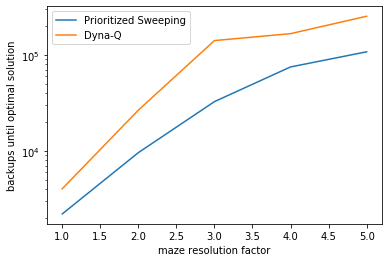

In [16]:
# Example 8.4, mazes with different resolution
def example_8_4():
    # get the original 6 * 9 maze
    original_maze = Maze()

    # set up the parameters for each algorithm
    params_dyna = DynaParams()
    params_dyna.planning_steps = 5
    params_dyna.alpha = 0.5
    params_dyna.gamma = 0.95

    params_prioritized = DynaParams()
    params_prioritized.theta = 0.0001
    params_prioritized.planning_steps = 5
    params_prioritized.alpha = 0.5
    params_prioritized.gamma = 0.95

    params = [params_prioritized, params_dyna]

    # set up models for planning
    models = [PriorityModel, TrivialModel]
    method_names = ['Prioritized Sweeping', 'Dyna-Q']

    # due to limitation of my machine, I can only perform experiments for 5 mazes
    # assuming the 1st maze has w * h states, then k-th maze has w * h * k * k states
    num_of_mazes = 5

    # build all the mazes
    mazes = [original_maze.extend_maze(i) for i in range(1, num_of_mazes + 1)]
    methods = [prioritized_sweeping, dyna_q]

    # My machine cannot afford too many runs...
    runs = 5

    # track the # of backups
    backups = np.zeros((runs, 2, num_of_mazes))

    for run in range(0, runs):
        for i in range(0, len(method_names)):
            for mazeIndex, maze in zip(range(0, len(mazes)), mazes):
                print('run %d, %s, maze size %d' % (run, method_names[i], maze.WORLD_HEIGHT * maze.WORLD_WIDTH))

                # initialize the state action values
                q_value = np.zeros(maze.q_size)

                # track steps / backups for each episode
                steps = []

                # generate the model
                model = models[i]()

                # play for an episode
                while True:
                    steps.append(methods[i](q_value, model, maze, params[i]))

                    # print best actions w.r.t. current state-action values
                    # printActions(currentStateActionValues, maze)

                    # check whether the (relaxed) optimal path is found
                    if check_path(q_value, maze):
                        break

                # update the total steps / backups for this maze
                backups[run, i, mazeIndex] = np.sum(steps)

    backups = backups.mean(axis=0)

    # Dyna-Q performs several backups per step
    backups[1, :] *= params_dyna.planning_steps + 1

    for i in range(0, len(method_names)):
        plt.plot(np.arange(1, num_of_mazes + 1), backups[i, :], label=method_names[i])
    plt.xlabel('maze resolution factor')
    plt.ylabel('backups until optimal solution')
    plt.yscale('log')
    plt.legend()
    
example_8_4()

## Experction vs Sample

In [17]:
# for figure 8.7, run a simulation of 2 * @b steps
def b_steps(b):
    # set the value of the next b states
    # it is not clear how to set this
    distribution = np.random.randn(b)

    # true value of the current state
    true_v = np.mean(distribution)

    samples = []
    errors = []

    # sample 2b steps
    for t in range(2 * b):
        v = np.random.choice(distribution)
        samples.append(v)
        errors.append(np.abs(np.mean(samples) - true_v))

    return errors

100%|██████████| 100/100 [00:12<00:00,  8.09it/s]


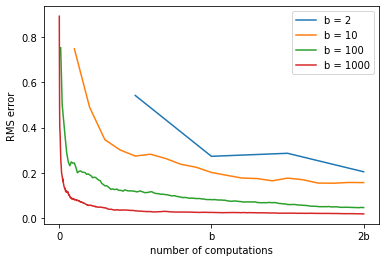

In [18]:
def figure_8_7():
    runs = 100
    branch = [2, 10, 100, 1000]
    for b in branch:
        errors = np.zeros((runs, 2 * b))
        for r in tqdm(np.arange(runs)):
            errors[r] = b_steps(b)
        errors = errors.mean(axis=0)
        x_axis = (np.arange(len(errors)) + 1) / float(b)
        plt.plot(x_axis, errors, label='b = %d' % (b))

    plt.xlabel('number of computations')
    plt.xticks([0, 1.0, 2.0], ['0', 'b', '2b'])
    plt.ylabel('RMS error')
    plt.legend()
figure_8_7()

In [20]:
distribution = np.random.randn(2)
distribution
np.mean(distribution)

0.09075281900795196

## Trajectory Sampling

In [21]:
# 2 actions
ACTIONS = [0, 1]

# each transition has a probability to terminate with 0
TERMINATION_PROB = 0.1

# maximum expected updates
MAX_STEPS = 20000

# epsilon greedy for behavior policy
EPSILON = 0.1

In [22]:
class Task():
    # @n_states: number of non-terminal states
    # @b: branch
    # Each episode starts with state 0, and state n_states is a terminal state
    def __init__(self, n_states, b):
        self.n_states = n_states
        self.b = b

        # transition matrix, each state-action pair leads to b possible states
        self.transition = np.random.randint(n_states, size=(n_states, len(ACTIONS), b))

        # it is not clear how to set the reward, I use a unit normal distribution here
        # reward is determined by (s, a, s')
        self.reward = np.random.randn(n_states, len(ACTIONS), b)

    def step(self, state, action):
        if np.random.rand() < TERMINATION_PROB:
            return self.n_states, 0
        next = np.random.randint(self.b)
        return self.transition[state, action, next], self.reward[state, action, next]

In [26]:
# Evaluate the value of the start state for the greedy policy
# derived from @q under the MDP @task
def evaluate_pi(q, task):
    # use Monte Carlo method to estimate the state value
    runs = 1000
    returns = []
    for r in range(runs):
        rewards = 0
        state = 0
        while state < task.n_states:
            action = np.argmax(q[state])
            state, r = task.step(state, action)
            rewards += r
        returns.append(rewards)
    return np.mean(returns)

In [27]:
# perform expected update from a uniform state-action distribution of the MDP @task
# evaluate the learned q value every @eval_interval steps
def uniform(task, eval_interval):
    performance = []
    q = np.zeros((task.n_states, 2))
    for step in tqdm(range(MAX_STEPS)):
        state = step // len(ACTIONS) % task.n_states
        action = step % len(ACTIONS)

        next_states = task.transition[state, action]
        q[state, action] = (1 - TERMINATION_PROB) * np.mean(
            task.reward[state, action] + np.max(q[next_states, :], axis=1))

        if step % eval_interval == 0:
            v_pi = evaluate_pi(q, task)
            performance.append([step, v_pi])

    return zip(*performance) # make list into tuple having two elements

In [28]:
# perform expected update from an on-policy distribution of the MDP @task
# evaluate the learned q value every @eval_interval steps
def on_policy(task, eval_interval):
    performance = []
    q = np.zeros((task.n_states, 2))
    state = 0
    for step in tqdm(range(MAX_STEPS)):
        if np.random.rand() < EPSILON:
            action = np.random.choice(ACTIONS)
        else:
            action = np.argmax(q[state])

        next_state, _ = task.step(state, action)

        next_states = task.transition[state, action]
        q[state, action] = (1 - TERMINATION_PROB) * np.mean(
            task.reward[state, action] + np.max(q[next_states, :], axis=1))

        if next_state == task.n_states:
            next_state = 0
        state = next_state

        if step % eval_interval == 0:
            v_pi = evaluate_pi(q, task)
            performance.append([step, v_pi])

    return zip(*performance) # make list into tuple having two elements

100%|██████████| 20000/20000 [00:03<00:00, 6303.13it/s]
/home/hyunsu/anaconda3/envs/gym/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


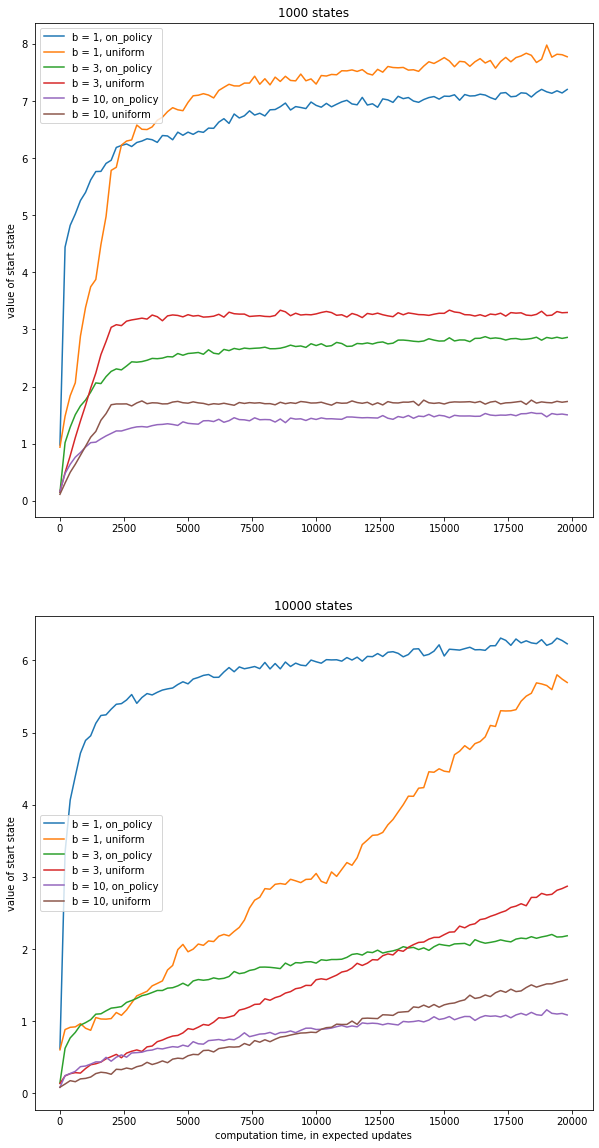

In [30]:
def figure_8_8():
    num_states = [1000, 10000]
    branch = [1, 3, 10]
    methods = [on_policy, uniform] # retrieve function

    # average accross 30 tasks
    n_tasks =  30

    # number of evaluation points
    x_ticks = 100

    plt.figure(figsize=(10, 20))
    for i, n in enumerate(num_states):
        plt.subplot(2, 1, i+1)
        for b in branch:
            tasks = [Task(n, b) for _ in range(n_tasks)]
            for method in methods:
                value = []
                for task in tasks:
                    steps, v = method(task, MAX_STEPS / x_ticks) # retrieve function
                    value.append(v)
                value = np.mean(np.asarray(value), axis=0)
                plt.plot(steps, value, label='b = %d, %s' % (b, method.__name__))
        plt.title('%d states' % (n))

        plt.ylabel('value of start state')
        plt.legend()

    plt.subplot(2, 1, 2)
    plt.xlabel('computation time, in expected updates')

figure_8_8()